# Introduction to Variational Bayesian Methods

### Written by D. Schleuter and C. Fonnesbeck

In Bayesian analysis, the most common strategy for computing posterior quantities is through Markov Chain Monte Carlo (MCMC). Despite recent advances in efficient sampling, MCMC methods still remain computationally intensive for more than a few thousand observations. A more scalable alternative to sampling is Variational Inference (VI), which re-frames the problem of computing the posterior distribution as a minimization of the Kullback-Leibler divergence between the true posterior and a member of some approximating family. 

In this lecture, we provide a basic overview of the VI framework as well as practical examples of its implementation using the Automatic Differentiation Variational Inference (ADVI) engine in PyMC3.

There are a couple of alternatives to evaluating complex posterior distributions without using an MCMC algorithm:

1. Divide and Conquer approaches: See [this paper](https://arxiv.org/abs/1311.4780) or [this paper](https://arxiv.org/abs/1508.05880) for more details

2. One alternative approach is to build an approximation to the posterior $p(\theta|X)$ using some other distribution $q(\theta)$

Let's focus on the latter option, and try to use a simple distribution to approximate a complex one.

## Distributional Approximations

We have already seen one example of a distributional approximation: the Laplace (normal) approximation. In that scenario, we constructed a Taylor series of the posterior and threw away the terms of higher than quadratic order. 

Variational inference is another distribitional approximation method. Here, rather than a Taylor series approximation, we choose some class of approximating distributions, and choose the member of that class which is **closest to the posterior**.

Thus, we shift from a stochastic sampling approach to approximation to a deterministic approximation that places bounds on the density of interest, then uses opimization to choose from that bounded set.

## Example: Approximating a Student's t with a gaussian 
Let's approximate a Students-t distribution with $\nu =3$  with a Gaussian distribution of some mean and variance.

One naive approach would be to build a set of test points and minimize the MSE between the $\log p(z)$ and $\log q(z)$. 

$$
{\hat \phi} = \underset{\phi}{{\rm arg\,min}} \frac{\sum_{i} q(\theta_{i};\phi)\left[\log q(\theta_{i};\phi) - \log p(\theta_{i})\right]^{2}}{\sum_{i} q(\theta_{i};\phi)}
$$

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import copy
import time
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="theano")
warnings.filterwarnings("ignore", module="scipy")

sns.set(style='ticks')

In [2]:
ν = 3
logp = sp.stats.t(ν).logpdf

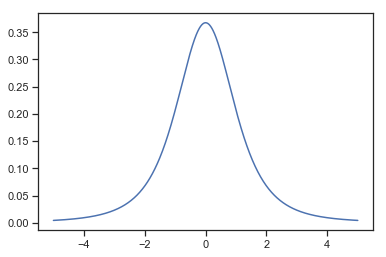

In [3]:
z = np.linspace(-5.0, 5.0, 1000)
plt.plot(z, np.exp(logp(z)), label='p(z)');

### Implementing the approximation

Let's weight points that have more probability in the approximation $q(z)$, the idea being that points near the bulk of  $q(\theta)$ are more important to get right. OK. 

How do we pick $\theta_i$? Well, let's use the known distribution of  $q(\theta;\phi)$  at each step of the optimization to select a grid of points which sample the regions of highest probability density. Then we will optimize the objective function that we defined in terms of MSE. 

In [4]:
def logq(θ, mu, lnsigma):
    # log-Gaussian parameterized by mean and log(sigma)
    sigma = np.exp(lnsigma)
    return sp.stats.norm(mu, sigma).logpdf(θ)

Now we can specify an objective function, and fit the normal distribition using `scipy.optimize`

In [5]:
def regression_vi(logp, n, mu_start, lnsigma_start, atol=1e-6):
    """use an optimizer for simple 1D VI"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes sum above on a grid.
    def obj(phi):
        _sigma = np.exp(phi[1])  # get sigma
        
        # This is the grid, factor of 10 is a random choice.
        z = np.linspace(phi[0] - 10.0*_sigma , phi[0] + 10.0*_sigma, n)

        # Build weights and differences.
        logqz = logq(z, phi[0], phi[1])
        w = np.exp(logqz)
        diff = logqz - logp(z)
        return np.sum(diff * diff * w) / np.sum(w)

    # Run the optimizer.
    opts = {'disp': True, 'maxiter': 5000, 'maxfev': 5000,
            'fatol': atol, 'xatol': 1e-8}
    phi_hat = sp.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options=opts)
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = regression_vi(logp, 100, 100.0, -100.0)

Optimization terminated successfully.
         Current function value: 0.034185
         Iterations: 107
         Function evaluations: 206
 final_simplex: (array([[-3.31217268e-09,  1.39418201e-01],
       [-4.22756079e-10,  1.39418205e-01],
       [ 5.89924420e-09,  1.39418199e-01]]), array([0.03418518, 0.03418518, 0.03418518]))
           fun: 0.03418517538400142
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 107
        status: 0
       success: True
             x: array([-3.31217268e-09,  1.39418201e-01])


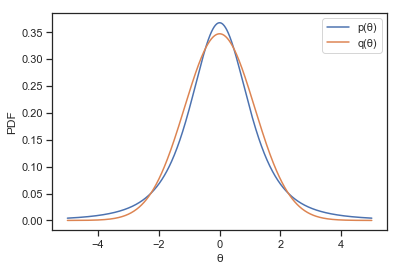

In [6]:
θ = np.linspace(-5.0, 5.0, 1000)
pθ = np.exp(logp(θ))
qθ = np.exp(logq(θ, phi_hat[0], phi_hat[1]))

plt.plot(θ, pθ, label='p(θ)')
plt.plot(θ, qθ, label='q(θ)')
plt.xlabel('θ')
plt.ylabel('PDF')
plt.legend();

MSE is not an effective criterion for comparing two arbitrary distributions (its only optimal when the approximation error is normally distributed). Instead, we can adopt a more robust information-theoretic measure, such as the **Kullback-Leibler divergence**, which estimates the information distance between two densities.

Hence we look to minimize the KL divergence between the approximating distribution and the truth:

$$
\begin{eqnarray*}
D_{\rm KL}\big(Q||P\big) &=& \int q(\theta) \log\frac{q(\theta)}{p(\theta)}d\theta\\
&=& \int q(\theta)\log q(\theta)d\theta - \int q(\theta)\log p(\theta)d\theta
\end{eqnarray*}
$$

In [7]:
def kl_vi(logp, n, mu_start, lnsigma_start):
    """vi with KL divergence"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        # Also known as the differential entropy.
        # For a Gaussian, it can be computed exactly. 
        # See wikipedia or something.
        entropy = phi[1] + 0.5*np.log(2.0 * np.pi) + 0.5 ## 
        
        # now we need to evaluate the second integral in the KL divergence, let's numerically approximate it with a sum
        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        θ = np.linspace(phi[0] - 20.0*_sigma , phi[0] + 20.0*_sigma, n) #number of grid points 
        dθ = θ[1] - θ[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqθ = logq(θ, phi[0], phi[1]) #just evaluate the variational density at each z on the grid and 
                                        # at the current value of phi
        qθ = np.exp(logqθ) # back transform
        return -entropy - np.sum(qθ * logp(θ) * dθ) #KL divergence for this phi
    
    # Pass this objective function to a scipy optimizer
    phi_hat = sp.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi(logp, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.040695
         Iterations: 56
         Function evaluations: 108
 final_simplex: (array([[-4.26771590e-06,  2.31270951e-01],
       [ 5.19733032e-05,  2.31261077e-01],
       [ 5.67321110e-05,  2.31314504e-01]]), array([0.04069546, 0.04069546, 0.04069546]))
           fun: 0.04069545533493302
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 56
        status: 0
       success: True
             x: array([-4.26771590e-06,  2.31270951e-01])


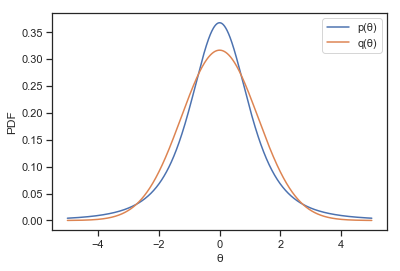

In [8]:
θ = np.linspace(-5.0, 5.0, 1000)
pθ = np.exp(logp(θ))
qθ = np.exp(logq(θ, phi_hat[0], phi_hat[1]))

plt.plot(θ, pθ, label='p(θ)')
plt.plot(θ, qθ, label='q(θ)')
plt.xlabel('θ')
plt.ylabel('PDF')
plt.legend();

## Let's look at a more difficult pdf to approximate:
$$
 \log p(\theta) = 10^{3}\log \theta + \log(1-\theta) - c
$$

where the constant $c \sim Beta(10^3+1, 2)$.

A naive approach here would be to fit a rescaled Gaussian to match the support of $\theta$

In [9]:
def logq_unit(θ, mu, lnsigma):
    """log of Gaussian parameterized by mean and log(sigma)
    has unit integral over 0,1 
    and value zero outside of 0,1
    """
    val = np.zeros_like(θ)
    msk = (θ >= 1.0) | (θ <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        sigma = np.exp(lnsigma)
        a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
        val[~msk] = sp.stats.truncnorm.logpdf(θ[~msk], a=a, b=b, loc=mu, scale=sigma)
    
    return val

def logp_hard(θ, a=1e3, b=1):
    val = np.zeros_like(θ)
    msk = (θ >= 1.0) | (θ <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        val[~msk] = a * np.log(θ) + b * np.log(1.0 - θ) - sp.special.betaln(a + 1.0, b + 1.0)
    return val

def kl_vi_unit(logp, n, mu_start, lnsigma_start, eps=1e-8):
    """vi with KL divergence over unit integral"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        sigma = np.exp(phi[1])
        a, b = (0.0 - phi[0]) / sigma, (1.0 - phi[0]) / sigma
        entropy = sp.stats.truncnorm.entropy(a=a, b=b, loc=phi[0], scale=sigma)

        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        θ = np.linspace(eps, 1.0 - eps, n)
        dθ= θ[1] - θ[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqθ = logq_unit(θ, phi[0], phi[1])
        qθ = np.exp(logqθ)

        return -entropy - np.sum(qθ * logp(θ) * dθ)

    # Run the optimizer.
    phi_hat = sp.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True, 'maxfev': 10000})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi_unit(logp_hard, 10000, 0.0, 0.0)

/Users/AlvinMBA/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/Users/AlvinMBA/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Optimization terminated successfully.
         Current function value: 0.145730
         Iterations: 231
         Function evaluations: 427
 final_simplex: (array([[ 0.9981397 , -6.63765288],
       [ 0.99813979, -6.63771762],
       [ 0.99813975, -6.63760831]]), array([0.14572997, 0.14572997, 0.14572997]))
           fun: 0.14572997442662317
       message: 'Optimization terminated successfully.'
          nfev: 427
           nit: 231
        status: 0
       success: True
             x: array([ 0.9981397 , -6.63765288])


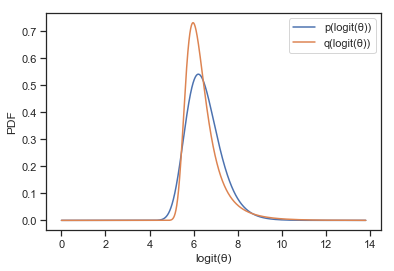

In [10]:
θ = np.linspace(0.5, 0.999999, 100000)
pθ = np.exp(logp_hard(θ))
qθ = np.exp(logq_unit(θ, phi_hat[0], phi_hat[1]))
dθ_dlogitθ = θ * (1.0 - θ)

plt.plot(sp.special.logit(θ), pθ * dθ_dlogitθ, label='p(logit(θ))')
plt.plot(sp.special.logit(θ), qθ * dθ_dlogitθ, label='q(logit(θ))')
plt.xlabel('logit(θ)')
plt.ylabel('PDF')
plt.legend();

This looks a little weird and rescaling a gaussian to squeeze into the support of $\theta$ is not really a good solution if your parameters all have different supports.

Instead, let's do the reverse and transform the parameter space to that of a gaussian.
A transformation $T$ that maps $[0,1] \to R$ is the logit function. 
$$
T(\theta)=\zeta = {\rm logit}(\theta) = \log\left(\frac{\theta}{1-\theta}\right)\\
{\rm logit}^{-1}(\zeta) = {\rm sigmoid}(\zeta) = \frac{1}{1 + \exp\left(-\zeta\right)}\\
\frac{d{\rm sigmoid}(\zeta)}{d\zeta} = {\rm sigmoid}(\zeta) \left[1 - {\rm sigmoid}(\zeta)\right]\\
$$
and then our pdf in terms of the transformed parameter is given by
$$
\begin{eqnarray}
 \log p_{\zeta}(\zeta) &=& \log p({\rm sigmoid}(\zeta)) + \log\left|\frac{d{\rm sigmoid}(\zeta)}{d\zeta}\right|\\
&=& \log p({\rm sigmoid}(\zeta)) + \log {\rm sigmoid}(\zeta) + \log(1-{\rm sigmoid}(\zeta))\ .
\end{eqnarray}
$$

In [11]:
def logp_easy(logitθ, a=1e3, b=1):
    logabsjac = -1.0 * (np.log(1.0 + np.exp(-logitθ)) + np.log(1.0 + np.exp(logitθ)))
    return (-a * np.log(1.0 + np.exp(-logitθ)) - b * np.log(1.0 + np.exp(logitθ)) + 
            logabsjac - 
            sp.special.betaln(a + 1.0, b + 1.0))

phi_hat, res = kl_vi(logp_easy, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.041045
         Iterations: 65
         Function evaluations: 126
 final_simplex: (array([[ 6.46509387, -0.34497398],
       [ 6.46518205, -0.34488247],
       [ 6.46511969, -0.34501641]]), array([0.04104499, 0.04104499, 0.041045  ]))
           fun: 0.04104499398863126
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 65
        status: 0
       success: True
             x: array([ 6.46509387, -0.34497398])


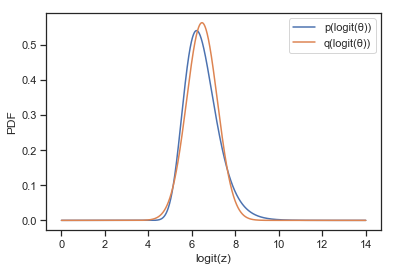

In [12]:
logitθ = np.linspace(0.0, 14.0, 100000)
plogitθ = np.exp(logp_easy(logitθ))
qlogitθ = np.exp(logq(logitθ, phi_hat[0], phi_hat[1]))

plt.plot(logitθ, plogitθ, label='p(logit(θ))')
plt.plot(logitθ, qlogitθ, label='q(logit(θ))')
plt.xlabel('logit(z)')
plt.ylabel('PDF')
plt.legend();

Clearly re-casting $\theta$ to have the same support as a Gaussian makes for nice and easy minimization and fits much better than the other way around. 

We will use this as a general strategy for automating variational inference.


## Approximating an unknown posterior distribution

Let's revisit the KL divergence and see what is available to us:

\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi}D_{\rm KL}(q(\theta; \phi) || p(\theta|X))
\end{equation}


The KL divergence is given by

\begin{eqnarray}
D_{\rm KL}\big(Q||P\big)&=& \int q(\theta) \log\frac{q(\theta)}{p(\theta|x)}d\theta\\
&=& E_q\left[\log\frac{q(\theta)}{p(\theta|x)}\right]\\
&=&E_q[\log q(\theta)]-E_q[\log p(\theta|x)]\\
&=&-E_q[\log p(\theta,x)]+E_q[\log q(\theta)]+\log p(x)\\
&=& -ELBO +\log p(x)
\end{eqnarray}

Notice that the KL divergence is given by the sum of the ELBO (evidence of lower bound) and Model Evidence. To see why, let's revisit the model evidence. 

\begin{eqnarray*}
\log p(x)&=&\log\int p(x,\theta)d\theta\\
&=&\log\int p(x,\theta)\frac{q(\theta)}{q(\theta)}d\theta\\
&=&\log(E_{q}\left[\frac{p(x,\theta)}{q(\theta)}\right])\\
&\geq& E_q[\log p(x,\theta)]-E_q[\log q(\theta)].
\end{eqnarray*}

This is due to the fact that logarithms are strictly concave, allowing us to invoke [**Jensen's inequality**](http://mathworld.wolfram.com/JensensInequality.html):

> Let $f$ be a convex function (*i.e.* $f^{\prime\prime} \ge 0$) of a random variable X. Then:
> $f(E[X]) \ge E[f(X)]$
>
> And when $f$ is *strictly* convex, then:
> $$E[f(X)] = f(E[X]) \iff X = E[X]$$
> with probability 1.

What this implies for a computational solution is that minimizing the KL divergence is accomplished by maximizing the evidence lower bound.



## [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788): A Tale of Two Transformations
With ease of computation in mind, Kucukelbir et. al. 2015 developed a way to perform VI automatically. Without going into too much detail (see reference for details), the authors proposed transforming the problem in a series of steps:

1. Specify the joint model, $p(x,\theta)$
2. Transform model into surrogate containing unconstrained real-valued latent variables, $\zeta$. $p(x,\theta) \to p(x,\zeta)$
    - Variational inference is then performed on the transformed model. New objective: 
    
$$
\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi} KL(q(\zeta; \phi)||p(\zeta|x))
\end{equation}
$$

all latent variables are defined on the same space. ADVI can now use a single variational family for all models
 
3. ADVI recasts the gradient of the variational objective function as an expectation over $q$. This allows for the use of Monte Carlo integration to perform the optimization
4. Next, the framework transforms the problem again and re-casts the gradient in terms of a standard Gaussian distribution. This makes MC integration very efficient since sampling is done from $N(0,1)$
5. Compute noisy gradients to optimize the objective. 


## Let's get a little bit of a feel for how this happens 

Remember, we're first going to transform all of our parameters to have the same support in $R^k$. We next need to optimize the KL divergence on the transformed space (like in the sigmoid transformation above). 

To accomplish this, we need to optimize the ELBO for the transformed objective. Our objective function for the transformed variables is now given by the ELBO of the transformation:

$$
ELBO(\phi) = E_{q(\zeta;\phi)}\left[\log p(x,T^{-1}(\zeta))+\log|\det J_{T^{-1}}(\zeta)|\right] - E_q[\log q(\zeta;\phi)]
$$




This notation is starting to get a litle hairy, so let's return to basics. Remember, the first expectation is just an expectation over a joint likelihood in terms of the approximating variational distribution.  

$$
\int q(z)\log p(x,T^{-1}(\zeta))|\det J_{T^{-1}}(\zeta)| dz \approx \frac{1}{n}\sum_i \log p(x|\zeta_{i})p(\zeta_{i})
$$

Problem is, we can't differentiate this MC integration with respect to the variational parameters (since they parameterize the distribution from which we draw $\zeta_i$). So we need to transform one more time so that the expectation is in terms of a standard normal (this is called elliptic standardization), and them perform MC integration with a draw from a standard normal. 

$$\begin{align}
\int q(\zeta) \log p(x|\zeta)p(\zeta) d\zeta &= \int N(\zeta) \log p(x|\zeta\sigma+\mu)p(\zeta\sigma+\mu) dz \\
&\approx \frac{1}{n}\sum_i \log p(x|\zeta_{i}\sigma+\mu)p(\zeta_{i}\sigma+\mu)\ .
\end{align}$$

Now, since this integral is explicitly in terms of the variational parameters, we can optimize our objective. 

![](images/advi.png)

## Above is something we can take derivatives of using a computational backend. We'll use pymc3 in a moment. But let's return to our weird pdf.

We can now implement a really crude version of advi on our weird pdf:

In [13]:
def dlogp_easy_dζ(ζ):
    θ = sp.special.expit(ζ)
    return (1e3 + 1.0) * (1.0 - θ) - 2 * θ

def kl_vi_with_sgd(dlogp, mu, lnsigma, rng, n_iter=100000, n_draw=1, eta=5e-4, eta_decay=5e-5):
    for i in range(n_iter):
        # Draw the points and convert back to draws from the variational approximation.
        ζ_standard = rng.normal(size=n_draw)
        sigma = np.exp(lnsigma)
        ζ = ζ_standard*sigma + mu
        
        # Compute the derivs.
        dkl_dmu = -np.mean(dlogp(ζ))
        dkl_dlnsigma = -np.mean(dlogp(ζ) * ζ_standard * sigma) - 1
        
        # Now do SGD with the KL divergence.
        lnsigma -= dkl_dlnsigma * eta
        mu -= dkl_dmu * eta
        
        # Decay the learning rate.
        eta *= 1.0 - eta_decay
        
        if not (i % (n_iter // 25)):
            print("iter, mu, lnsigma: % 7d|% 10.4e|% 10.4e" % 
                  (i, mu, lnsigma))
        
    return np.array([mu, lnsigma])

rng = np.random.RandomState(seed=5678)
phi_hat = kl_vi_with_sgd(dlogp_easy_dζ, 0.0, 0.0, rng)

iter, mu, lnsigma:       0| 3.3518e-01|-2.3741e-01
iter, mu, lnsigma:    4000| 6.3373e+00|-4.7391e-01
iter, mu, lnsigma:    8000| 6.4378e+00|-3.4406e-01
iter, mu, lnsigma:   12000| 6.4592e+00|-3.5437e-01
iter, mu, lnsigma:   16000| 6.4571e+00|-3.4403e-01
iter, mu, lnsigma:   20000| 6.4656e+00|-3.5536e-01
iter, mu, lnsigma:   24000| 6.4663e+00|-3.6306e-01
iter, mu, lnsigma:   28000| 6.4572e+00|-3.5847e-01
iter, mu, lnsigma:   32000| 6.4657e+00|-3.5701e-01
iter, mu, lnsigma:   36000| 6.4643e+00|-3.5113e-01
iter, mu, lnsigma:   40000| 6.4556e+00|-3.4125e-01
iter, mu, lnsigma:   44000| 6.4647e+00|-3.4658e-01
iter, mu, lnsigma:   48000| 6.4712e+00|-3.4985e-01
iter, mu, lnsigma:   52000| 6.4660e+00|-3.4201e-01
iter, mu, lnsigma:   56000| 6.4645e+00|-3.4355e-01
iter, mu, lnsigma:   60000| 6.4649e+00|-3.4346e-01
iter, mu, lnsigma:   64000| 6.4657e+00|-3.4193e-01
iter, mu, lnsigma:   68000| 6.4624e+00|-3.4012e-01
iter, mu, lnsigma:   72000| 6.4602e+00|-3.3670e-01
iter, mu, lnsigma:   76000| 6.4

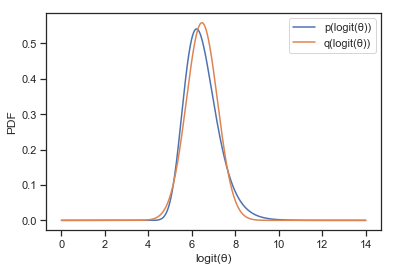

In [14]:
logitθ = np.linspace(0.0, 14.0, 100000)
plogitθ = np.exp(logp_easy(logitθ))
qlogitθ = np.exp(logq(logitθ, phi_hat[0], phi_hat[1]))

plt.plot(logitθ, plogitθ, label='p(logit(θ))')
plt.plot(logitθ, qlogitθ, label='q(logit(θ))')
plt.xlabel('logit(θ)')
plt.ylabel('PDF')
plt.legend();

But we certainly don't want to have to compute derivatives all by hand!

## Variational Inference in PyMC3

Theano, PyTorch, and Tensorflow are all computational backends to compute derivatives symbolically so we don't have to hand code anything. PyMC3 uses Theano which is what we will be working in.






In [15]:
import pymc3 as pm
import theano.tensor as tt

size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

Okay let's plot this:

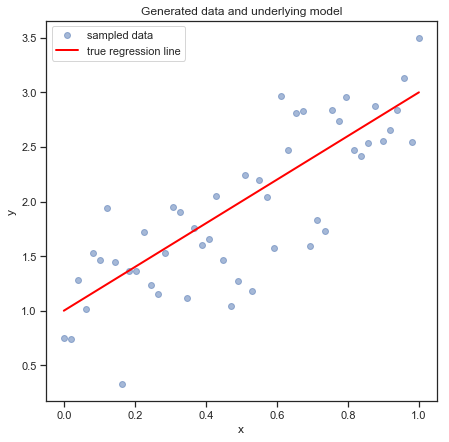

In [16]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
#plt.plot(x, y,"bo", label='sampled data', alpha =0.01)
ax.plot(x, y,"bo", label='sampled data',alpha =0.5)
ax.plot(x, true_regression_line, label='true regression line', lw=2.,color = "red")
plt.legend(loc=0);

In [19]:
with pm.Model() as model:
    
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)
    
    trace = pm.sample(1000, tune=2000, njobs=2) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:07<00:00, 788.36draws/s]


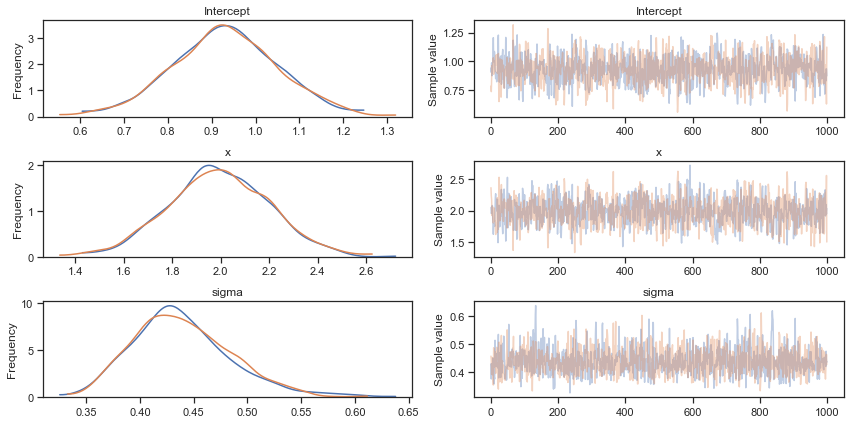

In [20]:
pm.traceplot(trace);

In [21]:
with model:
    approx = pm.fit(n=20000)

Average Loss = 43.957: 100%|██████████| 20000/20000 [00:21<00:00, 944.63it/s]
Finished [100%]: Average Loss = 43.972


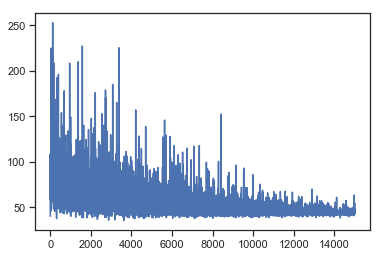

In [22]:
plt.plot(approx.hist[5000:]);

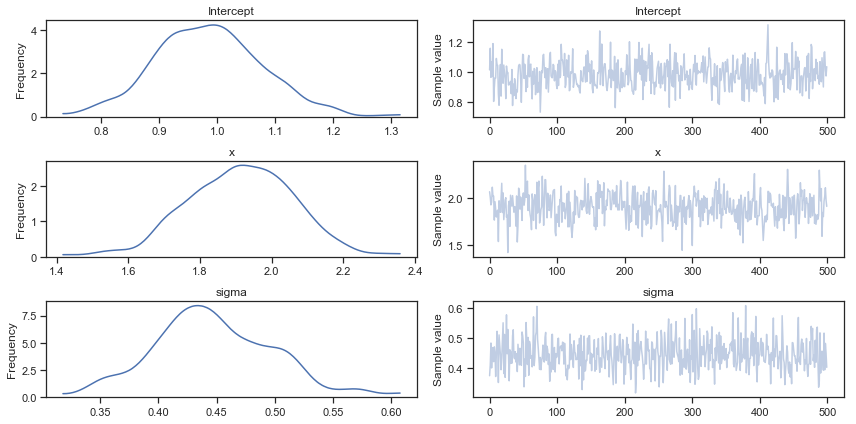

In [23]:
trace_vi = approx.sample(draws=500) 
pm.traceplot(trace_vi);

Here, `trace_vi` acts exactly like a trace from mcmc. 

### Mean field variational inference

By default, `fit` employs a mean field assumption regarding the model parameters. This assumes the variational distribution factors independently: 

$$q(\theta_1, \ldots, \theta_n) = q(\theta_1) \cdots q(\theta_n)$$

We can generalize this to use a full-rank covariance matrix for our approximation, which carries an associated tradeoff in performance.

In [24]:
with model:
    approx_fr = pm.fit(n=20000, method='fullrank_advi')

Average Loss = 42.901: 100%|██████████| 20000/20000 [00:35<00:00, 559.34it/s]
Finished [100%]: Average Loss = 42.897


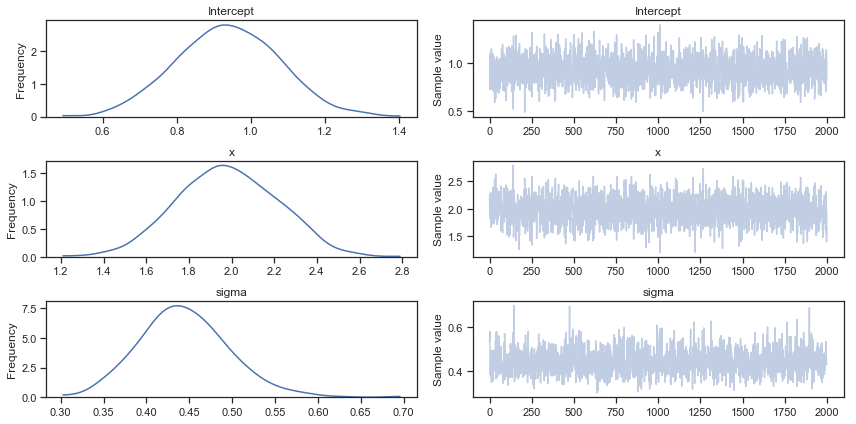

In [26]:
trace_fullrank = approx_fr.sample(draws=2000) 
pm.traceplot(trace_fullrank);

## Exercise: Drug trial analysis

To illustrate how variational inference works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

Construct a model for estimating the effect size of the drug. Fit this model using both MCMC and ADVI, and compare the resulting estimates.

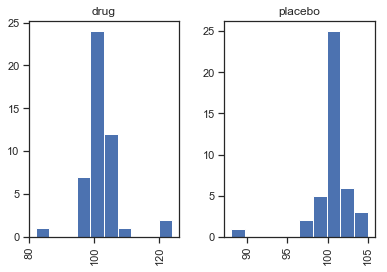

In [27]:
import pandas as pd
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

In [47]:
x = [1] * len(drug)
x.extend([0] * len(placebo))

In [48]:
len(x)

89

In [42]:
len(np.asarray(y['value']))

89

In [60]:
# Write your answer here

### this is not right at all (as of 10/23/18) - need to check out Chris's code 
### looks like he did something similar to the HW #2 with creating group means & using a deterministic for 
### difference in group means

with pm.Model() as exercise:
    
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                           sd=sigma, observed=np.asarray(y['value']))
    
    trace2 = pm.sample(1000, tune=2000, njobs=2) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:06<00:00, 880.13draws/s] 


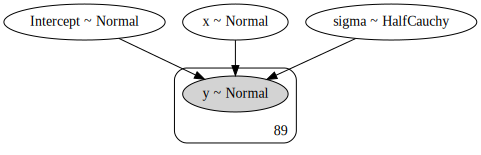

In [61]:
pm.model_to_graphviz(exercise)

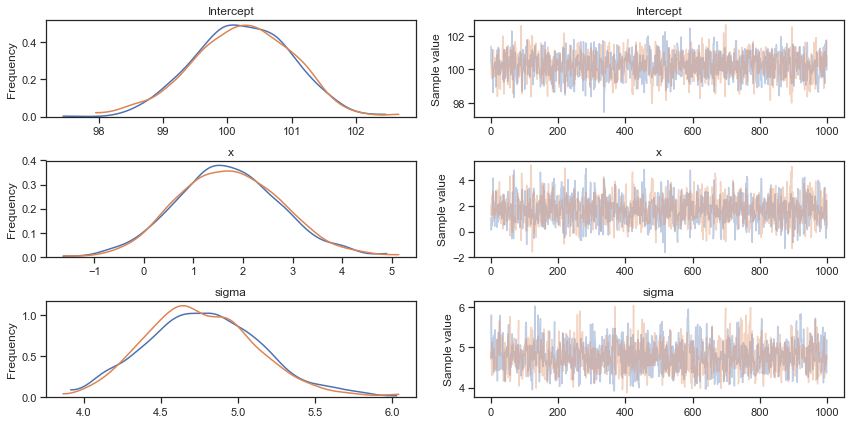

In [62]:
pm.traceplot(trace2);

In [63]:
with exercise:
    approx2 = pm.fit(n=20000)

Average Loss = 538.74: 100%|██████████| 20000/20000 [00:17<00:00, 1114.54it/s]   
Finished [100%]: Average Loss = 538.73


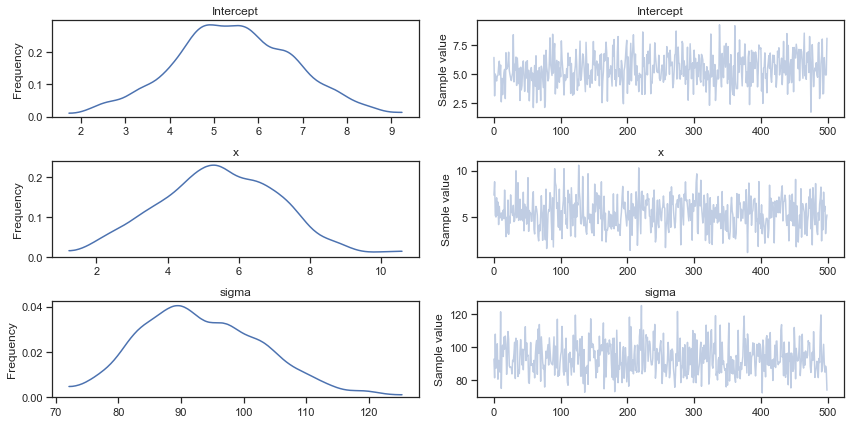

In [64]:
trace_vi = approx2.sample(draws=500) 
pm.traceplot(trace_vi);

In [65]:
with exercise:
    approx2_fr = pm.fit(n=20000, method='fullrank_advi')

Average Loss = 537.43: 100%|██████████| 20000/20000 [00:30<00:00, 666.06it/s]   
Finished [100%]: Average Loss = 537.45


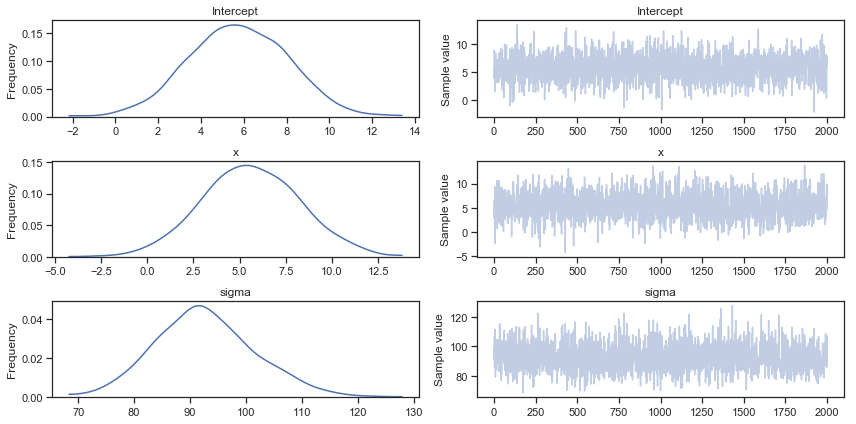

In [66]:
trace_fullrank = approx2_fr.sample(draws=2000) 
pm.traceplot(trace_fullrank);

## Example: Mixture model

Let's look at using VI to estimate a simple, but less straightforward model: a mixture model that features a bimodal posterior distribution. Mixture models can be specified easily in PyMC3 with the `Mixture` class, that accepts a set of densities and an associated set of weights. 

In [67]:
w = np.array([.2, .8])
mu = np.array([-.3, .5])
sd = np.array([.1, .1])

with pm.Model() as mixture_model:
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd)
    x2 = pm.Deterministic('x2', x ** 2)
    sin_x = pm.Deterministic('sin_x', pm.math.sin(x))

In [68]:
with mixture_model:
    mixture_trace = pm.sample(10000, tune=5000, njobs=2, random_seed=(1, 42))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:14<00:00, 2087.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


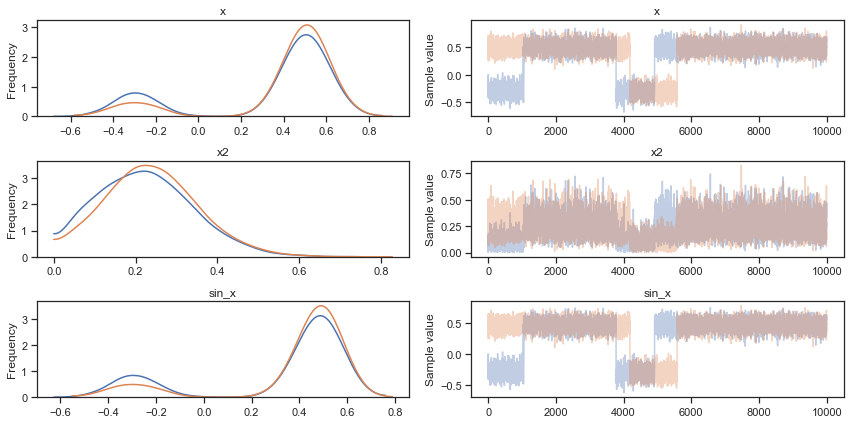

In [69]:
pm.traceplot(mixture_trace);

The NUTS algorithm is easily able to sample from the distribution. Let's try to replicate the analysis with mean-field VI:

In [70]:
with mixture_model:
    mean_field = pm.fit()

Average Loss = 2.1864: 100%|██████████| 10000/10000 [00:08<00:00, 1234.33it/s]
Finished [100%]: Average Loss = 2.185


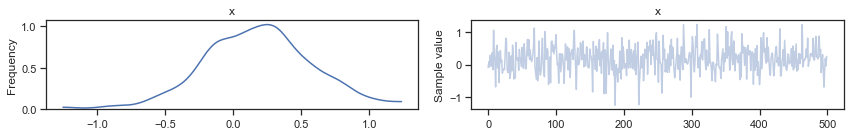

In [71]:
meanfield_trace = mean_field.sample(500)
pm.traceplot(meanfield_trace, varnames=['x']);

Notice that ADVI has failed to approximate the multimodal distribution, since it uses a Gaussian distribution that has a single mode.

## Checking convergence

The `fit` function supports the use of "callbacks", which are functions that are passed as arguments to other functions, and executed at a specified time within that function. For example, the `CheckParametersConvergence` callback will monitor the model parameter trajectories, and stop the VI algoithm when convergence is achieved.

In [72]:
from pymc3.variational.callbacks import CheckParametersConvergence

with mixture_model:
    mean_field = pm.fit(callbacks=[CheckParametersConvergence()])

Average Loss = 2.2288: 100%|██████████| 10000/10000 [00:07<00:00, 1260.17it/s]
Finished [100%]: Average Loss = 2.2202


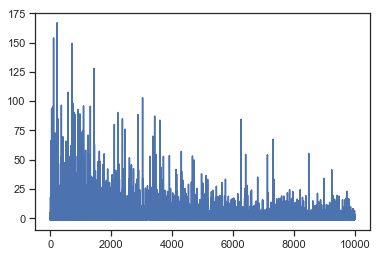

In [73]:
plt.plot(mean_field.hist);

It appears that the model did not converge, despite the fact that we ran many iterations. In this case, this is because the mean of the ADVI approximation is close to zero, so taking the relative difference (the default method) is an unstable convergence check.

Let's try again, using absolute difference as the criterion:

In [74]:
with mixture_model:
    mean_field = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = 2.3245:  91%|█████████ | 9070/10000 [00:07<00:00, 1158.94it/s]
Convergence achieved at 9100
Interrupted at 9,099 [90%]: Average Loss = 3.7656


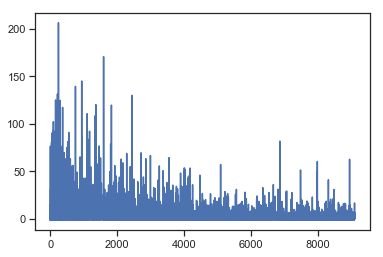

In [75]:
plt.plot(mean_field.hist);

That's much better! We've reached convergence after approximately 5000 iterations.

## Tracking parameters

Another useful callback allows users to track parameters directly during the fitting procedure. To do this we need to use the object-oriented (OO) API, which allows direct access to the approximation before inference is performed.

In [76]:
with mixture_model:
    advi = pm.ADVI()

In [77]:
advi.approx

Different approximations have different hyperparameters. In mean-field ADVI, we have $\rho$ and $\mu$ (inspired by [Bayes by BackProp](https://arxiv.org/abs/1505.05424)).

In [78]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

There are convenient shortcuts to relevant statistics associated with the approximation. This can be useful, for example, when specifying a mass matrix for NUTS sampling:

In [79]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

We can roll these statistics into the `Tracker` callback.

In [80]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

Now, calling `advi.fit` will record the mean and standard deviation of the approximation as it runs.

In [81]:
approx = advi.fit(20000, callbacks=[tracker])

Average Loss = 2.1364: 100%|██████████| 20000/20000 [00:18<00:00, 1081.12it/s]
Finished [100%]: Average Loss = 2.1474


We can now plot both the evidence lower bound and parameter traces:

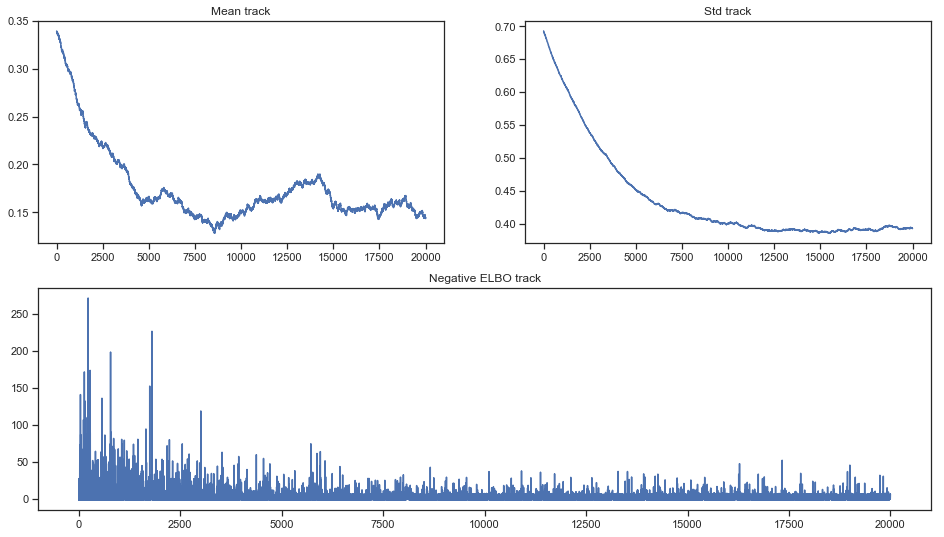

In [82]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

Notice that there are convergence issues with the mean, and that lack of convergence does not seem to change the ELBO trajectory significantly. As we are using the OO API, we can run the approximation longer until convergence is achieved.

In [83]:
advi.refine(10000)

Average Loss = 1.9752: 100%|██████████| 10000/10000 [00:09<00:00, 1063.66it/s]
Finished [100%]: Average Loss = 1.9774


Let's take a look:

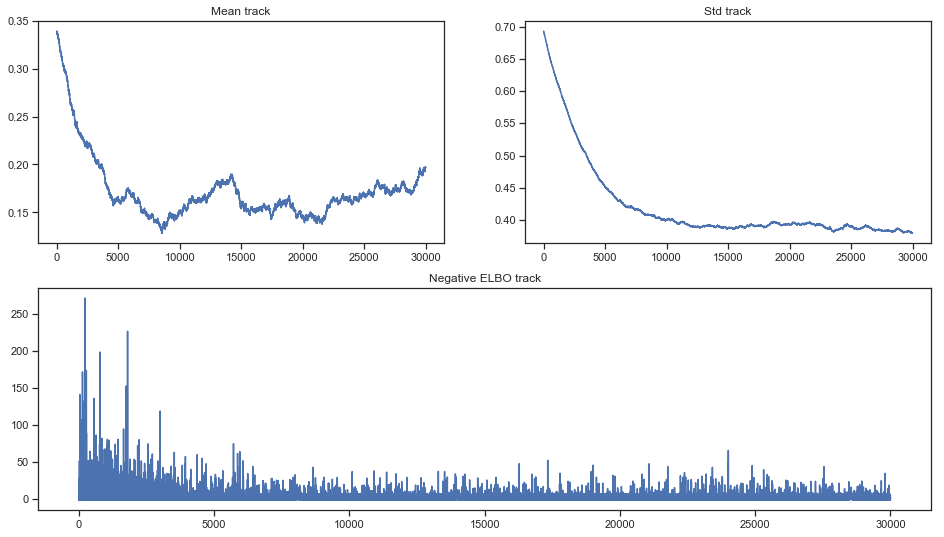

In [84]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

We still see evidence for lack of convergence, as the mean has devolved into a random walk. This could be the result of choosing a poor algorithm for inference. At any rate, it is unstable and can produce very different results even using different random seeds.

Let's compare results with the NUTS output:

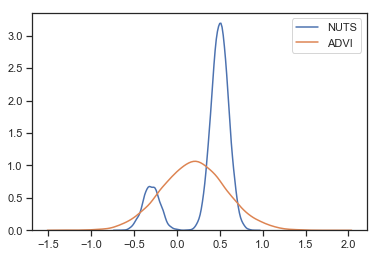

In [85]:
import seaborn as sns
ax = sns.kdeplot(mixture_trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');

## Stein Variational Gradient Descent (SVGD)

SVGD is a general VI algorithm that iteratively shifts a set of particles to match a target posterior. This is done via a form of functional gradient descent that minimizes the KL divergence.

1. Sample particles from prior distribution of parameters
2. Formulate bijective (i.e. reversible) transformation of particles
3. Iteratively apply transformation until convergence

SVGD directly minimizes $KL(\{x_i\} || p)$ by iteratively moving points $\{x_i\}_{i=1}^n$ towards the target p by updates of form:

$$x_i^{\prime} \leftarrow x_i + \epsilon\phi(xi)$$

where $\phi$ is a *perturbation direction* chosen to optimally decrease the KL divergence:

$$\phi = \text{argmax}_{\phi}\left\{-\frac{\partial}{\partial \epsilon} KL(q_{[\epsilon \phi]} || p)|_{\epsilon=0}\right\}$$

where $q_{[\epsilon \phi]}$ is the density of $x^{\prime}$ when the density of $x$ is $q$.

The name of the procedure reflects the fadt that this direction is related to the **Stein operator**:

$$-\frac{\partial}{\partial \epsilon} KL(q_{[\epsilon \phi]} || p)|_{\epsilon=0} = E_{x \sim q}[\mathcal{T}_p \phi(x)]$$

[SVGD visualization](https://chi-feng.github.io/mcmc-demo/app.html#SVGD,multimodal)

In [86]:
with mixture_model:
    svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000), 
                         obj_optimizer=pm.sgd(learning_rate=0.01))

100%|██████████| 300/300 [00:54<00:00,  5.55it/s]


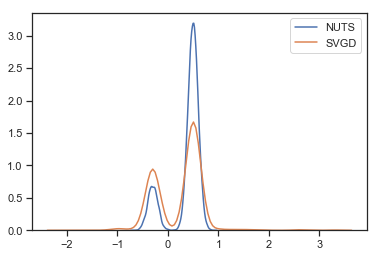

In [87]:
ax = sns.kdeplot(mixture_trace['x'], label='NUTS');
sns.kdeplot(svgd_approx.sample(2000)['x'], label='SVGD');

## Minibatches
When dealing with large datasets, using minibatch training can drastically speed up and improve approximation performance. Large datasets impose a hefty cost on the computation of gradients. 

Minibatch gradient descent is a variation of the gradient descent algorithm that divides a large dataset into (much) smaller batches, each of which are used to calculate gradients, model error and updated model coefficients. These "noisy" gradients are more robust to the presence of local minima, and avoid having to ever use the entire dataset to calculate a gradient.

There is a nice API in pymc3 to handle these cases, which is avaliable through the `pm.Minibatch` class. The minibatch is just a highly specialized Theano tensor:

In [88]:
issubclass(pm.Minibatch, tt.TensorVariable)

True

To demonstrate, let's simulate a large quantity of data:

In [89]:
# Raw values
data = np.random.rand(40000, 100) 
# Scaled values
data *= np.random.randint(1, 10, size=(100,))
# Shifted values
data += np.random.rand(100) * 10    

For comparison, let's fit a model without minibatch processing:

In [90]:
with pm.Model() as model:
    mu = pm.Flat('mu', shape=(100,))
    sd = pm.HalfNormal('sd', shape=(100,))
    like = pm.Normal('like', mu, sd, observed=data)

Just for fun, let's create a custom special purpose callback to halt slow optimization. Here we define a callback that causes a hard stop when approximation runs too slowly:

In [91]:
def stop_after_10(approx, loss_history, i):
    if (i > 0) and (i % 10) == 0:
        raise StopIteration('I was slow, sorry')

In [92]:
with model:
    advifit = pm.fit(callbacks=[stop_after_10])

Average Loss = 4.9733e+08:   0%|          | 9/10000 [00:01<32:35,  5.11it/s]
I was slow, sorry
Interrupted at 9 [0%]: Average Loss = 6.2569e+08


Inference is too slow, taking several seconds per iteration; fitting the approximation would have taken hours!

Instead, let's use minibatches. At every iteration, we will draw 500 random values. Since PyMC3 variables are just Theano variables, we can swap data in and out of the likelihood at each iteration. However, we need to provide the total size of the dataset in order for the model to be properly specified.

In [93]:
X = pm.Minibatch(data, batch_size=500)

with pm.Model() as model:
    
    mu = pm.Flat('mu', shape=(100,))
    sd = pm.HalfNormal('sd', shape=(100,))
    # class note 10/23/18: this is the only time that we have to actually change our model specification, 
    # which we do by noting the total size of the data
    likelihood = pm.Normal('likelihood', mu, sd, observed=X, total_size=data.shape)

/Users/AlvinMBA/anaconda/envs/bios8366/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [94]:
with model:
    advifit = pm.fit()

Average Loss = 1.6282e+05: 100%|██████████| 10000/10000 [00:23<00:00, 420.52it/s]
Finished [100%]: Average Loss = 1.6274e+05


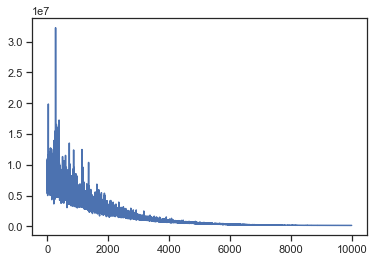

In [95]:
plt.plot(advifit.hist);

Minibatch inference is dramatically faster. Multidimensional minibatches may be needed for some corner cases where you do matrix factorization or model is very wide.

Here is the docstring for `Minibatch` to illustrate how it can be customized.

## Exercise: Minibatch ADVI

Try using minibatch ADVI on the regression model:

1. Simulate a dataset of size n=50,000
2. Set up the model to fit to this data using minibatch

In [ ]:
# Write your answer here

---
## References: 

1. [Variational Inference from the ground up](https://www.civisanalytics.com/blog/variational-inference-ground/)
2. [Automatic Differentiation Variational Inference. Kucukelbir, A., Tran D., Ranganath, R., Gelman, A., and Blei, D. M. (2016)](https://arxiv.org/abs/1603.00788)
2. [Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe (2016)](https://arxiv.org/abs/1601.00670)